<a href="https://colab.research.google.com/github/GabrielFurnielesGarcia/deeplearning-2024/blob/main/IAGenerativa/LAB03_1_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# LAB 03 - Ejercicio 1 - Variational Autoencoder
#### Gabriel Furnieles y Sofia Ángel

## Librerías necesarias

In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model, metrics, losses

## Carga y preprocesamiento del dataset

In [18]:
# Cargar y preprocesar Fashion MNIST
(x_train, _), (x_test, _) = fashion_mnist.load_data()
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255

## Implementando un VAE con Keras

Vamos a implementar un **VAE que pueda generar dígitos MNIST**. Va a tener tres partes:
* Una **red encoder** que **convierte una imagen real** en una **media y una varianza en el espacio latente**
* Una **capa de muestreo** que **toma dicha media y varianza**, y las usa para **muestrear un punto aleatorio del espacio latente**
* Una **red decoder** que **convierte los puntos del espacio latente en imágenes**

### Modelo 1

In [19]:
# Dimensionalidad del espacio latente, un plano 2D
latent_dim = 2

# Encoder
encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [20]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 14, 14, 32)           320       ['input_4[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d_4[0][0]']            
                                                                                                  
 flatten_1 (Flatten)         (None, 3136)                 0         ['conv2d_5[0][0]']            
                                                                                            

El siguiente código es para **generar un punto espacial latente ``z``** usando ``z_mean`` y ``z_log_var``, los parámetros de la distribución estadística que se supone que produjeron ``input_img``:

**Capa de muestreo-espacio-latente (Latent-space-sampling)**

In [21]:
# Sampling layer
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

El siguiente código es la **implementación del decodificador**. Redimensionamos el vector ``z`` a las dimensiones de una imagen y luego usamos algunas capas de convolución para obtener una salida de imagen final que tiene las mismas dimensiones que la ``input_img`` original.

**Red de decodificadores VAE, asignando puntos de espacio latente a imágenes**

In [22]:
# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
#Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [23]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 1)         289 

Creamos el **propio modelo VAE**. **Este es nuestro primer ejemplo de un modelo que no realiza aprendizaje supervisado** (un autoencoder es un ejemplo de **aprendizaje autosupervisado**, porque **utiliza sus entradas como objetivos**). Cada vez que se sale del aprendizaje supervisado clásico, es **común crear una subclase de la clase ``Model`` e implementar un ``train_ step()`` personalizado para especificar la nueva lógica de entrenamiento**

In [24]:
# VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:
# Instanciar el modelo VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())

In [16]:
# Entrenar el modelo VAE
vae.fit(fashion_mnist, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 133s 239ms/step - total_loss: 317.1064 - reconstruction_loss: 311.5762 - kl_loss: 5.5301
Epoch 2/30
547/547 [==============================] - 129s 236ms/step - total_loss: 276.3710 - reconstruction_loss: 271.5001 - kl_loss: 4.8712
Epoch 3/30
547/547 [==============================] - 131s 240ms/step - total_loss: 271.5631 - reconstruction_loss: 267.0355 - kl_loss: 4.5274
Epoch 4/30
547/547 [==============================] - 130s 237ms/step - total_loss: 269.4906 - reconstruction_loss: 265.0825 - kl_loss: 4.4080
Epoch 5/30
547/547 [==============================] - 131s 239ms/step - total_loss: 267.7407 - reconstruction_loss: 263.3935 - kl_loss: 4.3474
Epoch 6/30
547/547 [==============================] - 130s 237ms/step - total_loss: 266.5414 - reconstruction_loss: 262.2272 - kl_loss: 4.3141
Epoch 7/30
547/547 [==============================] - 132s 241ms/step - total_loss: 265.6426 - reconstruction_loss: 261.3496 - kl_loss: 4.2929

La pérdida total es una combinación de la pérdida de reconstrucción y la pérdida de divergencia de Kullback-Leible
La pérdida de reconstrucción representa cuánto difieren las imágenes generadas del modelo de las imágenes de entrada originales.
La divergencia de Kullback-Leibler (KL) es una medida de cuánto se desvían dos distribuciones de probabilidad una de la otra. En el contexto del modelo Variational Autoencoder (VAE), la divergencia KL se utiliza para medir cuánto difiere la distribución de probabilidad de los vectores latentes generados por el modelo de una distribución de referencia, típicamente una distribución gaussiana estándar.

In [19]:
print("La pérdida total fue: {:.4f}".format(total_loss[-1]))
print("La pérdida de reconstrucción fue: {:.4f}".format(reconstruction_loss[-1]))
print("La pérdida de divergencia de Kullback-Leibler (KL) fue: {:.4f}".format(kl_loss[-1]))

La pérdida total fue: 257.6887
La pérdida de reconstrucción fue: 253.5603
La pérdida de divergencia de Kullback-Leibler (KL) fue: 4.1282


Estos resultados sugieren que el modelo VAE está aprendiendo a reconstruir las imágenes originales con una pérdida de reconstrucción relativamente baja y controla la dispersión en el espacio latente con una pérdida de divergencia KL razonable.


Ingrese el índice de la imagen a mostrar: 12
2188/2188 [==============================] - 37s 17ms/step


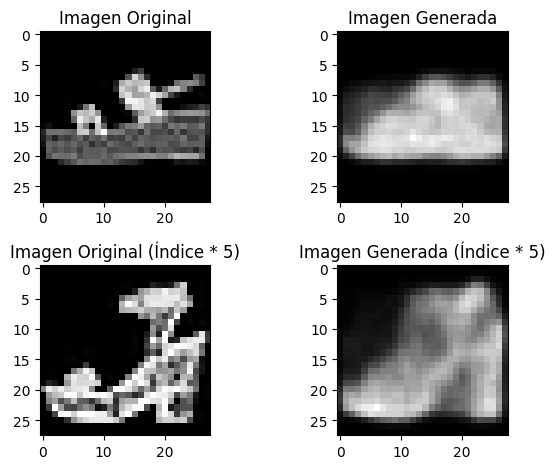

In [20]:
index = int(input("Ingrese el índice de la imagen a mostrar: "))

y_pred = vae.decoder.predict(vae.encoder.predict(fashion_mnist)[0])

plt.figure(1)
plt.subplot(221)
plt.imshow(fashion_mnist[index].reshape(28,28), cmap='gray')
plt.title("Imagen Original")

plt.subplot(222)
plt.imshow(y_pred[index].reshape(28,28), cmap='gray')
plt.title("Imagen Generada")

plt.subplot(223)
plt.imshow(fashion_mnist[index*5].reshape(28,28), cmap='gray')
plt.title("Imagen Original 2")

plt.subplot(224)
plt.imshow(y_pred[index*5].reshape(28,28), cmap='gray')
plt.title("Imagen Generada 2")

plt.tight_layout()
plt.show()

Obtenemos una pequeña comparación entre imágenes originales del conjunto de datos y sus versiones reconstruidas generadas por un Autoencoder Variacional (VAE). La reconstrucción se realiza utilizando el codificador para mapear las imágenes al espacio latente y luego utilizando el decodificador para mapear de vuelta al espacio de entrada original.

Vayamos con otro ejemplo, con otro modelo, sin strides y aumentando el número de filtros podemos conseguir mejoras.

### Modelo 2

In [25]:
# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=1, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [26]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 28, 28, 64)           640       ['input_6[0][0]']             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 28, 28, 128)          73856     ['conv2d_7[0][0]']            
                                                                                                  
 flatten_2 (Flatten)         (None, 100352)               0         ['conv2d_8[0][0]']            
                                                                                            

In [27]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = layers.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(28 * 28 * 128, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((28, 28, 128))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=1, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

In [28]:
# VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# Instanciar el modelo VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
# Entrenar el modelo VAE
vae.fit(fashion_mnist, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 2081s 4s/step - total_loss: 290.1646 - reconstruction_loss: 284.3095 - kl_loss: 5.8556
Epoch 2/10
 12/547 [..............................] - ETA: 32:21 - total_loss: 272.2004 - reconstruction_loss: 267.8911 - kl_loss: 4.3093

In [ ]:
print("La pérdida total fue: {:.4f}".format(total_loss[-1]))
print("La pérdida de reconstrucción fue: {:.4f}".format(reconstruction_loss[-1]))
print("La pérdida de divergencia de Kullback-Leibler (KL) fue: {:.4f}".format(kl_loss[-1]))

Este modelo tiene valores de pérdida total más bajos al anterior, si bien es cierto, que la pérdida de reconstrucción es similar y la pérdida kl es más alta que en el anterior. Veamos que imágenes nos crea.

In [ ]:
index = int(input("Ingrese el índice de la imagen a mostrar: "))

y_pred = vae.decoder.predict(vae.encoder.predict(fashion_mnist)[0])

plt.figure(1)
plt.subplot(221)
plt.imshow(fashion_mnist[index].reshape(28,28), cmap='gray')
plt.title("Imagen Original")

plt.subplot(222)
plt.imshow(y_pred[index].reshape(28,28), cmap='gray')
plt.title("Imagen Generada")

plt.subplot(223)
plt.imshow(fashion_mnist[index*5].reshape(28,28), cmap='gray')
plt.title("Imagen Original 2")

plt.subplot(224)
plt.imshow(y_pred[index*5].reshape(28,28), cmap='gray')
plt.title("Imagen Generada 2")

plt.tight_layout()
plt.show()

Nos muestra imágenes de forma más clara.

## Conclusiones